In [2]:
import pandas as pd
import numpy as np
import subprocess
from itertools import chain, product
from scipy.misc import imread, imshow
import matplotlib.pyplot as plt

In [3]:
PARAMS_TO_FLAGS = {
    'input_file': '-i',
    'output_file': '-o',
    'rays': '-rays',
    'd_w': '-d_w',
    'd_h': '-d_h'
}


In [4]:
def parse_results(output, niters):
    N, time, eigen_val, *eigen_vec = list(map(float, output.decode().split('\n')[:-1]))
    return {
        'N': N,
        'time': time,
        'niters': niters,
        'eigen_val': eigen_val,
        'eigen_vec': np.array(eigen_vec),
    }


def output_to_dict(output):
    # Parsear la salida a un diccionario
    lines = output.decode().split('\n')
    d = dict(tuple(l.split(': ')) for l in lines if ': ' in l)
    for k, v in d.items():
        if k != 'Dataset File':
            d[k] = float(v)
    return d

def run(exc_path, params):
    args = tuple(chain(*((PARAMS_TO_FLAGS[p], str(v)) for p, v in params.items())))
    args = [exc_path, *args]
    output = subprocess.check_output(args)
    return output_to_dict(output)

-----------------------------------------------------------

## Visualizacion de Geometrias

/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


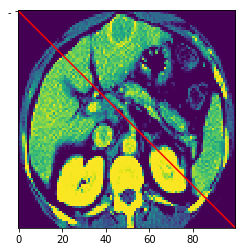

(100, 100)

In [35]:
def draw_ray(image, start, end):
    """
    Simulates a ray on an image im of shape (n, m)
    starting from start = (row_start, col_start)
    ending in end = (row_end, col_end).
    """
    rows, cols = image.shape
    x = np.array([start[0], end[0]])
    y = np.array([start[1], end[1]])
    z = np.polyfit(x, y, 1)
    # z_inv = np.polyfit(y, x, 1)

    b, a = z
    x = np.linspace(start[0], end[0], 100)
    y = np.array([a + e*b for e in x])
    return x, y

def simulate_rays(image, rays, draw=True):
    for start, end in rays:
        x, y = draw_ray(image, start, end)
        plt.plot(x, y, 'r', '-')
    plt.imshow(np.uint8(image))
    plt.show()

rays = [((0, 0), (100, 100))]
im = imread('../recursosTP3/data/tomo.png', 'L')
plt.imshow(np.uint8(im), cmap='Greys')
simulate_rays(im, rays)
im.shape

# Geometria Horizontal

TODO: Explicar

In [37]:
def end_coor(y_s, alpha, rows, cols):
    x_end = 256
    if 0 <= alpha <= np.pi / 2:
        y_end = y_s + np.tan(alpha) * cols
    else:
        y_end = y_s - np.tan(abs(alpha)) * cols
    
    if y_end > rows:
        y_end = rows
        x_end = min(abs(y_end - y_s) / np.tan(alpha), rows)
    if y_end < 0:
        y_end = 0
        x_end = min(abs(y_end - y_s) / np.tan(abs(alpha)), rows)
    return x_end, y_end

def generate_rays(im, h_resolution, a_resolution, alpha_min=-np.pi/2 , alpha_max=0):
    rays = []
    rows, cols = im.shape
    start_x = 0
    for start_y in np.linspace(0, rows, h_resolution):
        for angle in np.linspace(alpha_min, alpha_max, a_resolution):
            end_x, end_y = end_coor(start_y, angle, rows, cols)
            rays.append(((start_x, start_y), (end_x, end_y)))
    return rays

# generate_rays(im, 1, 5)
end_coor(153.60, -0.2443461, 256, 256)

(256, 89.77202998849532)

In [38]:
np.linspace(-np.pi / 10, 0, 10)

array([-0.31415927, -0.27925268, -0.2443461 , -0.20943951, -0.17453293,
       -0.13962634, -0.10471976, -0.06981317, -0.03490659,  0.        ])

In [39]:
(0, 153.60000000000002), (256, 0)
end_coor(153.60000000000002, -0.2443461, 256, 256)

(256, 89.77202998849535)

/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


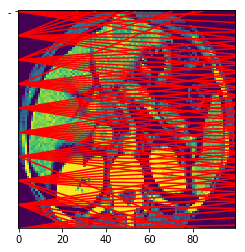

In [40]:
rays = generate_rays(im, 10, 10, alpha_min=-np.pi/8 , alpha_max=np.pi/8)
rays
simulate_rays(im, rays)

In [41]:
def rays_to_csv(outfname, rays_l):
    with open(outfname, 'w') as f:
        for ray in rays_l:
            f.write('{},{},{},{}\n'.format(ray[0][0], ray[0][1], 
                                         ray[1][0], ray[1][1]))

In [42]:
rays_to_csv("../recursosTP3/data/rays.csv", rays)

# Geometria Horizontal y Vertical

In [43]:
def end_coor_h(y_s, alpha, rows, cols):
    x_end = 256
    if 0 <= alpha <= np.pi / 2:
        y_end = y_s + np.tan(alpha) * cols
    else:
        y_end = y_s - np.tan(abs(alpha)) * cols
    
    if y_end > rows:
        y_end = rows
        x_end = min(abs(y_end - y_s) / np.tan(alpha), rows)
    if y_end < 0:
        y_end = 0
        x_end = min(abs(y_end - y_s) / np.tan(abs(alpha)), rows)
    return x_end, y_end

def end_coor_v(x_s, alpha, rows, cols):
    y_end = 256
    if 0 <= alpha <= np.pi / 2:
        x_end = x_s + np.tan(alpha) * rows
    else:
        x_end = x_s - np.tan(abs(alpha)) * rows
    
    if x_end > cols:
        x_end = cols
        y_end = min(abs(x_end - x_s) / np.tan(alpha), cols)
    if x_end < 0:
        x_end = 0
        y_end = min(abs(x_end - x_s) / np.tan(abs(alpha)), cols)
    return x_end, y_end

def generate_rays(im, h_resolution, a_resolution, alpha_min=-np.pi/2 , alpha_max=0):
    rays = []
    rows, cols = im.shape
    start_x = 0
    for start_y in np.linspace(0, rows, h_resolution):
        for angle in np.linspace(alpha_min, alpha_max, a_resolution):
            end_x, end_y = end_coor_h(start_y, angle, rows, cols)
            rays.append(((start_x, start_y), (end_x, end_y)))
    
    start_y = 0
    for start_x in np.linspace(0, cols, h_resolution):
        for angle in np.linspace(alpha_min, alpha_max, a_resolution):
            end_x, end_y = end_coor_v(start_x, angle, rows, cols)
            rays.append(((start_x, start_y), (end_x, end_y)))        
    
    return rays

# generate_rays(im, 1, 5)


/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/Users/juanmanuelbalodonado/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/

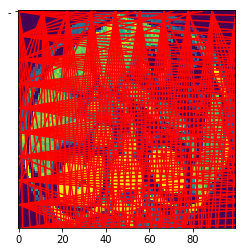

In [49]:
rays = generate_rays(im, 10, 10, alpha_min=-np.pi/8 , alpha_max=np.pi/8)
# rays
simulate_rays(im, rays)

In [47]:
len(rays)

1800

In [48]:
rays_to_csv("../recursosTP3/data/rays.csv", rays)

In [ ]:

def run()